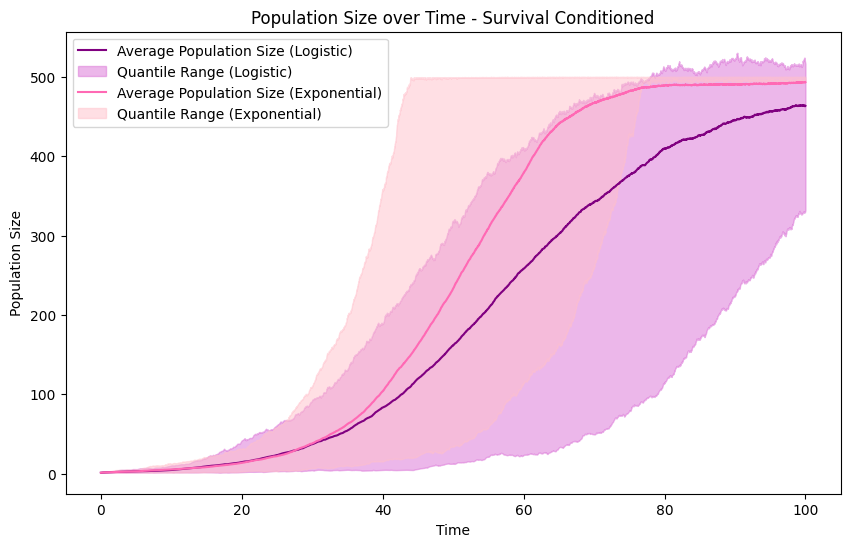

Extinction Probability (Logistic): 0.50
Extinction Probability (Exponential): 0.45


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.1, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation_logistic(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']

    time_points = [0]
    population_sizes = [population]

    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = birth_rate * (1 - population / carrying_capacity) + death_rate * (population / carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate * population + effective_birth_rate * population))
        
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1

        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)

    return time_points, population_sizes

def run_simulation_exponential(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    carrying_capacity = params['carrying_capacity']
    max_time = params['max_time']

    time_points = [0]
    population_sizes = [population]

    while population > 0 and time_points[-1] < max_time:
        next_event_time = np.random.exponential(1 / (death_rate * population + birth_rate * population))

        if np.random.rand() < birth_rate / (birth_rate + death_rate) and population < carrying_capacity:
            population += 1
        else:
            population -= 1

        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)

    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(model_func, params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']

    for _ in range(num_simulations):
        time_points, population_sizes = model_func(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1

    max_len = max(len(sim) for sim in all_time_points)
    num_points = max_len
    average_time_points = np.linspace(0, max_time, num_points)

    non_extinct_populations = [pop for pop in all_population_sizes if pop[-1] > 0]
    non_extinct_times = [time for time, pop in zip(all_time_points, all_population_sizes) if pop[-1] > 0]
    non_extinct_interpolations = np.zeros((len(non_extinct_populations), num_points))

    for i, (time, pop) in enumerate(zip(non_extinct_times, non_extinct_populations)):
        non_extinct_interpolations[i] = np.interp(average_time_points, time, pop)

    average_population_sizes = np.mean(non_extinct_interpolations, axis=0)
    lower_quantile = np.nanquantile(non_extinct_interpolations, 0.05, axis=0)
    upper_quantile = np.nanquantile(non_extinct_interpolations, 0.95, axis=0)

    extinction_probability = extinction_count / num_simulations

    return average_time_points, non_extinct_interpolations, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def plot_multiple_simulations_with_quantiles(average_time_points_logistic, average_population_sizes_logistic, lower_quantile_logistic, upper_quantile_logistic,
                                             average_time_points_exponential, average_population_sizes_exponential, lower_quantile_exponential, upper_quantile_exponential):
    plt.figure(figsize=(10, 6))

    # Plot for logistic model
    plt.plot(average_time_points_logistic, average_population_sizes_logistic, color='purple', linestyle='-', label='Average Population Size (Logistic)')
    plt.fill_between(average_time_points_logistic, lower_quantile_logistic, upper_quantile_logistic, color='orchid', alpha=0.5, label='Quantile Range (Logistic)')

    # Plot for exponential model
    plt.plot(average_time_points_exponential, average_population_sizes_exponential, color='hotpink', linestyle='-', label='Average Population Size (Exponential)')
    plt.fill_between(average_time_points_exponential, lower_quantile_exponential, upper_quantile_exponential, color='pink', alpha=0.5, label='Quantile Range (Exponential)')

    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.title('Population Size over Time - Survival Conditioned')
    plt.legend()
    plt.show()

# Parameters
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1)

# Run multiple simulations for logistic model
num_simulations = 100
average_time_points_logistic, non_extinct_interpolations_logistic, average_population_sizes_logistic, lower_quantile_logistic, upper_quantile_logistic, extinction_probability_logistic = run_multiple_simulations_with_quantiles(run_simulation_logistic, params, num_simulations)

# Run multiple simulations for exponential model
average_time_points_exponential, non_extinct_interpolations_exponential, average_population_sizes_exponential, lower_quantile_exponential, upper_quantile_exponential, extinction_probability_exponential = run_multiple_simulations_with_quantiles(run_simulation_exponential, params, num_simulations)

# Plot results
plot_multiple_simulations_with_quantiles(average_time_points_logistic, average_population_sizes_logistic, lower_quantile_logistic, upper_quantile_logistic,
                                         average_time_points_exponential, average_population_sizes_exponential, lower_quantile_exponential, upper_quantile_exponential)

# Print extinction probabilities
print(f"Extinction Probability (Logistic): {extinction_probability_logistic:.2f}")
print(f"Extinction Probability (Exponential): {extinction_probability_exponential:.2f}")
